Car order: ['WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC']


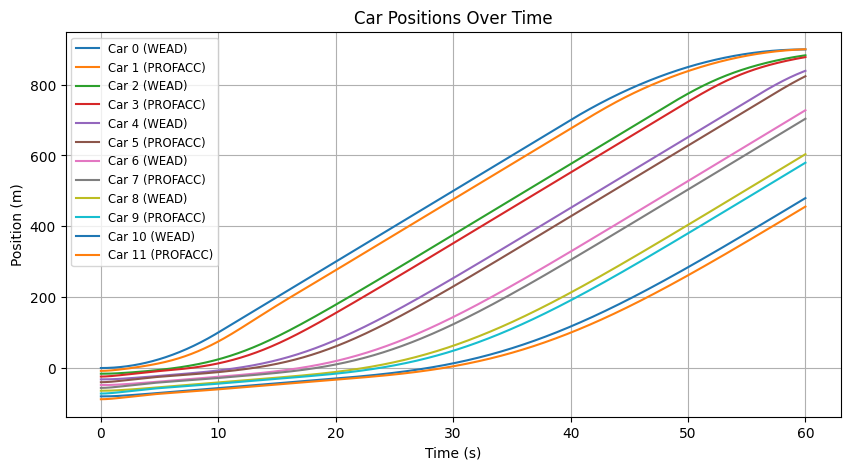

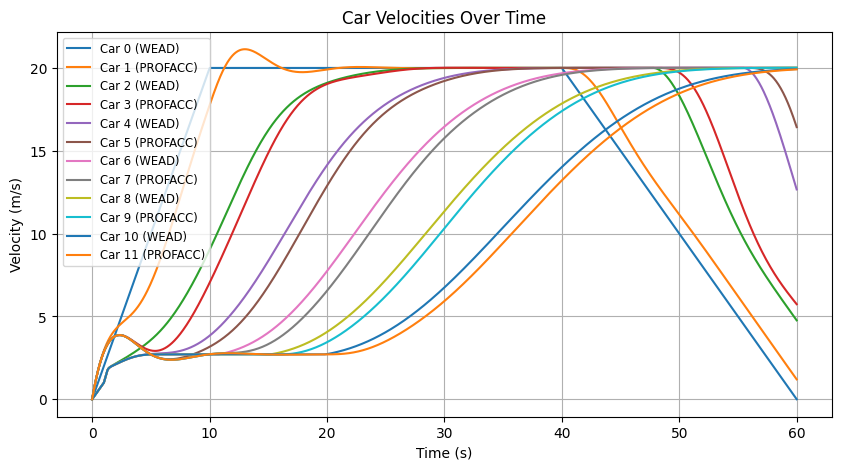

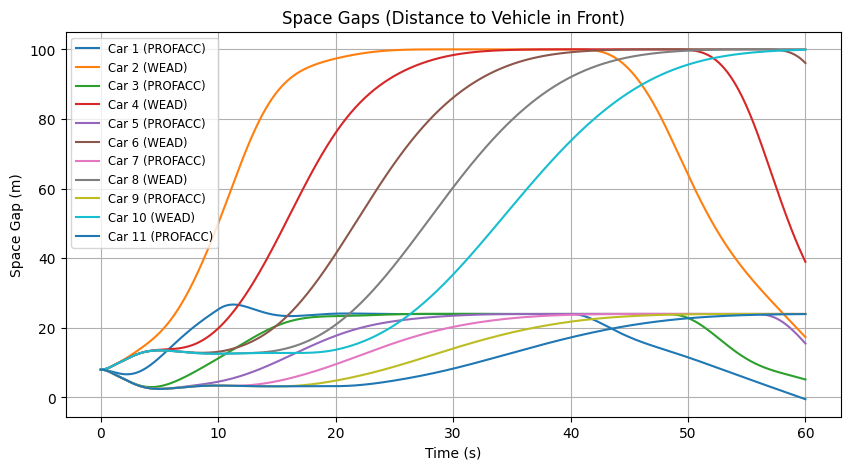

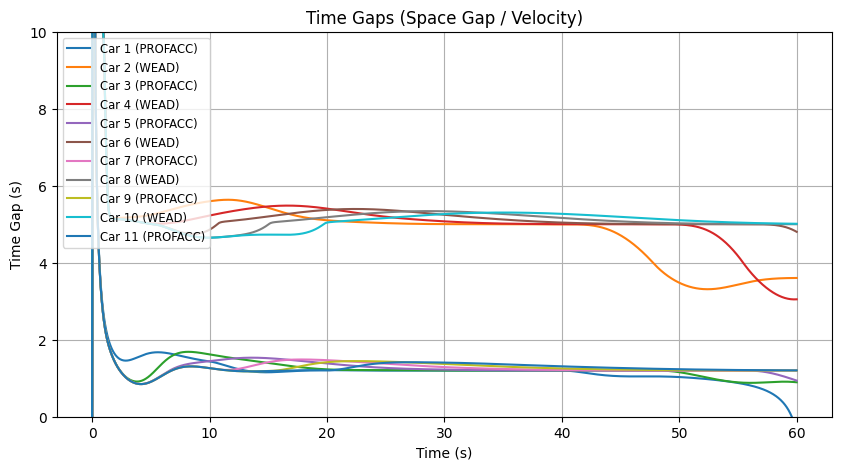

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
#  WEAD CONTROLLER
# ============================================================
def wead_controller(sn, vn):
    STOPPED_SPEED_TH = 1.0
    STOPPED_MIN_GAP = 5.0
    STOPPED_ACCEL = 1.0

    MAX_ACCEL = 2.5
    MAX_BRAKE = -2.5

    CRUISE_SPEED_LIMIT = 36.0

    if vn <= STOPPED_SPEED_TH:
        if sn > STOPPED_MIN_GAP:
            return STOPPED_ACCEL
        else:
            return 0.0

    time_gap = sn / vn if vn > 0 else float('inf')

    if time_gap <= 3:
        return MAX_BRAKE
    elif time_gap < 4:
        return (2.5 * time_gap) - 10
    elif time_gap <= 5:
        return 0.0
    elif time_gap < 6:
        return (2.5 * time_gap) - 12.5
    elif time_gap >= 6:
        return MAX_ACCEL if vn <= CRUISE_SPEED_LIMIT else 0.0

    return 0.0


# ============================================================
#  PROFACC CONTROLLER 
# ============================================================
def profacc_controller(sn, vn, alpha=0.5, tau=1.2):
    return alpha * (sn - tau * vn)


# ============================================================
# Leader velocity profile (Applied to Car 0)
# ============================================================
def car0_velocity_profile(t):
    if t < 10:
        return 2.0 * t              # accelerate to 20 m/s
    elif t < 40:
        return 20.0                 # cruise
    else:
        return max(0, 20 - 1*(t-40))  # brake


# ============================================================
#  CAR ORDERING FUNCTION
# ============================================================
def assign_controllers(num_wead, ordering):
    total = 12
    num_prof = total - num_wead

    if ordering == "front":
        return ["WEAD"] * num_wead + ["PROFACC"] * num_prof
    elif ordering == "back":
        return ["PROFACC"] * num_prof + ["WEAD"] * num_wead
    elif ordering == "interspersed":
        controller_list = ["PROFACC"] * total
        if num_wead > 0:
            spacing = total / num_wead
            for i in range(num_wead):
                idx = int(i * spacing)
                if idx < total:
                    controller_list[idx] = "WEAD"
        return controller_list
    else:
        raise ValueError("ordering must be 'front', 'back', or 'interspersed'")


# ============================================================
#  MAIN PLATOON SIMULATION
# ============================================================
def simulate_platoon(num_wead_cars, ordering):

    # Assign controllers to all cars (including Car 0, though Car 0 uses a fixed profile)
    controllers = assign_controllers(num_wead_cars, ordering)
    print("Car order:", controllers)

    dt = 0.05
    T = 60
    N = int(T/dt)

    t = np.linspace(0, T, N)

    # State arrays for 12 cars
    x = np.zeros((12, N))      # positions
    v = np.zeros((12, N))      # velocities
    a = np.zeros((12, N))      # accelerations
    
    # Metric arrays
    space_gaps = np.zeros((12, N)) # Gap to the car in front
    time_gaps  = np.zeros((12, N)) # space_gap / velocity

    # Initial positions (cars spaced 8 m apart)
    for i in range(12):
        x[i, 0] = -8 * i
        
        # Calculate initial gaps (valid for everyone except Car 0)
        if i > 0:
            space_gaps[i, 0] = x[i-1, 0] - x[i, 0]

    # Simulate
    for k in range(1, N):

        # === Car 0 Motion (Pre-defined Profile) ===
        v[0, k] = car0_velocity_profile(t[k])
        x[0, k] = x[0, k-1] + v[0, k] * dt
        # Car 0 has no one in front, so its gaps remain 0

        # === Follower Motion (Cars 1 through 11) ===
        for car in range(1, 12):
            
            # 1. Calculate Inputs based on the car directly in front (car-1)
            sn = x[car-1, k-1] - x[car, k-1]
            vn = v[car, k-1]
            
            # 2. Store metrics
            space_gaps[car, k] = sn
            if vn > 0.1:
                time_gaps[car, k] = sn / vn
            else:
                time_gaps[car, k] = 20.0 # Cap for plotting when stopped

            # 3. Calculate Control Output
            if controllers[car] == "WEAD":
                acc = wead_controller(sn, vn)
            else:
                acc = profacc_controller(sn, vn)

            # 4. Update State
            a[car, k] = acc
            v[car, k] = max(0, v[car, k-1] + acc * dt)
            x[car, k] = x[car, k-1] + v[car, k] * dt

    return t, x, v, space_gaps, time_gaps, controllers


# ============================================================
#  RUN + PLOT
# ============================================================
if __name__ == "__main__":
    # Setup
    num_wead_cars = 6           
    ordering = "interspersed"    

    # Run Simulation
    t, x, v, s_gaps, t_gaps, controllers = simulate_platoon(num_wead_cars, ordering)

    # ---- Plot Positions ----
    plt.figure(figsize=(10, 5))
    for car in range(12):
        # Uniform labeling for all cars
        plt.plot(t, x[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Car Positions Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

    # ---- Plot Velocities ----
    plt.figure(figsize=(10, 5))
    for car in range(12):
        plt.plot(t, v[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Car Velocities Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

    # ---- Plot Space-Gaps ----
    plt.figure(figsize=(10, 5))
    # We only plot gaps for cars that HAVE a car in front of them (1 to 11)
    for car in range(1, 12):
        plt.plot(t, s_gaps[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Space Gaps (Distance to Vehicle in Front)")
    plt.xlabel("Time (s)")
    plt.ylabel("Space Gap (m)")
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

    # ---- Plot Time-Gaps ----
    plt.figure(figsize=(10, 5))
    for car in range(1, 12):
        plt.plot(t, t_gaps[car], label=f"Car {car} ({controllers[car]})")
    plt.title("Time Gaps (Space Gap / Velocity)")
    plt.xlabel("Time (s)")
    plt.ylabel("Time Gap (s)")
    plt.ylim(0, 10) 
    plt.grid()
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

In [35]:
# ============================================================
# RUN VERSION: 3 WEAD + 9 PRO-FACC
# ============================================================

your_num_wead = 3
your_ordering = "interspersed"  # evenly spaced, as you designed

t2, x2, v2, s2, tg2, ctrl2 = simulate_platoon(your_num_wead, your_ordering)

print("Your controller assignment:", ctrl2)


Car order: ['WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC']
Your controller assignment: ['WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC', 'WEAD', 'PROFACC', 'PROFACC', 'PROFACC']


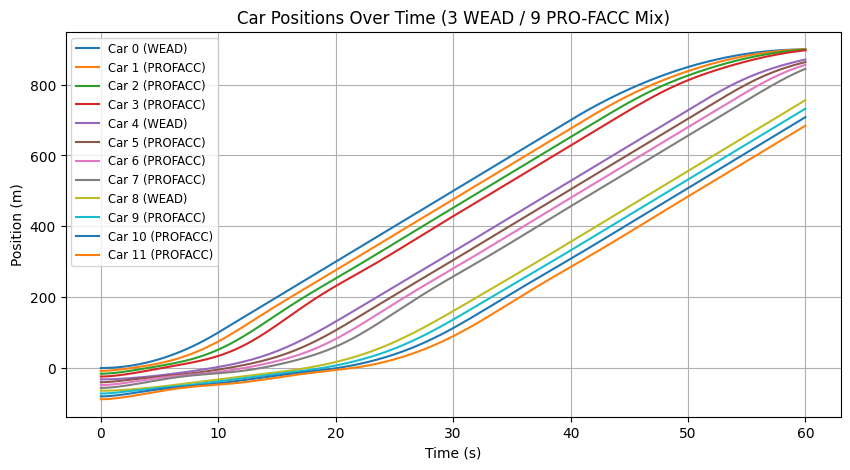

In [36]:
# ============================================================
# POSITIONS
# ============================================================

plt.figure(figsize=(10,5))
for car in range(12):
    plt.plot(t2, x2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Car Positions Over Time (3 WEAD / 9 PRO-FACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()


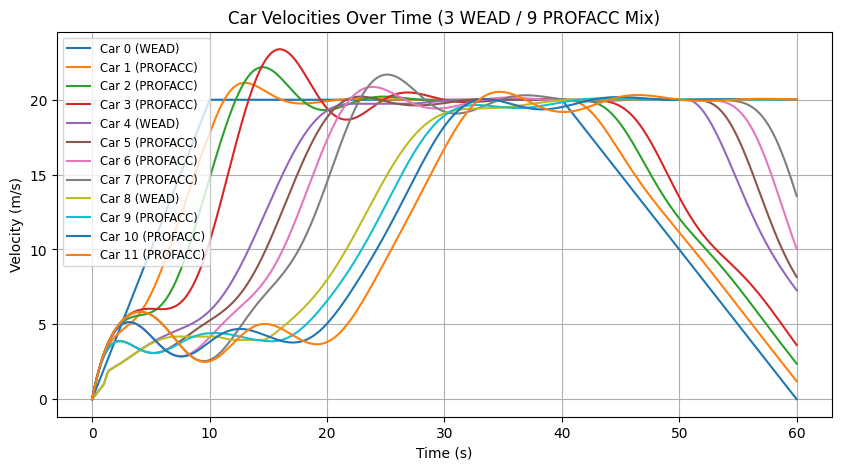

In [37]:
# ============================================================
# YOUR PLOTTING — VELOCITIES
# ============================================================

plt.figure(figsize=(10,5))
for car in range(12):
    plt.plot(t2, v2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Car Velocities Over Time (3 WEAD / 9 PROFACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()


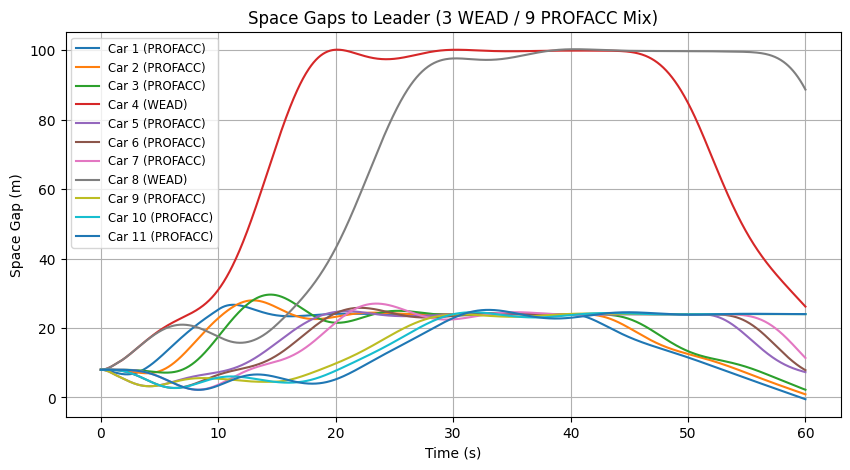

In [38]:
# ============================================================
# YOUR PLOTTING — SPACE GAPS
# ============================================================

plt.figure(figsize=(10,5))
for car in range(1, 12):  # no gap for Car 0
    plt.plot(t2, s2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Space Gaps to Leader (3 WEAD / 9 PROFACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Space Gap (m)")
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()


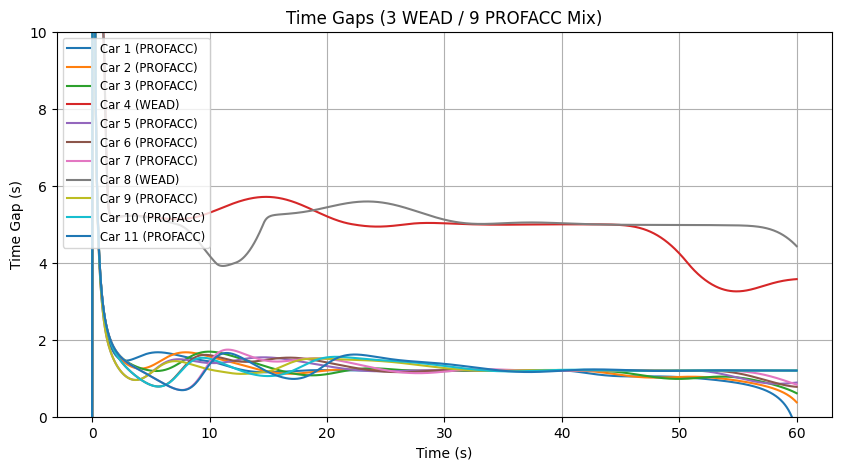

In [39]:
# ============================================================
# PLOTTING — TIME GAPS
# ============================================================

plt.figure(figsize=(10,5))
for car in range(1, 12):
    plt.plot(t2, tg2[car], label=f"Car {car} ({ctrl2[car]})")

plt.title("Time Gaps (3 WEAD / 9 PROFACC Mix)")
plt.xlabel("Time (s)")
plt.ylabel("Time Gap (s)")
plt.ylim(0, 10)
plt.grid()
plt.legend(loc='upper left', fontsize='small')
plt.show()


Running Fundamental Diagram Analysis...


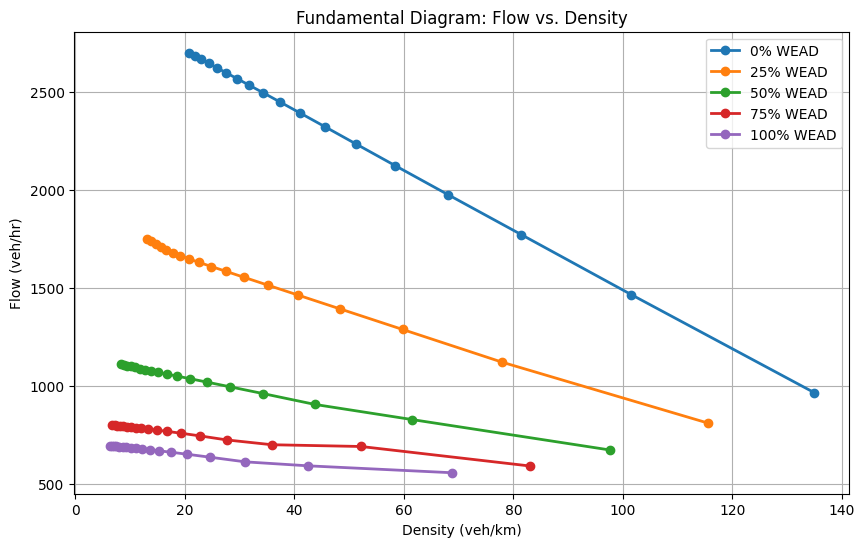

Running Stability & Energy Analysis...


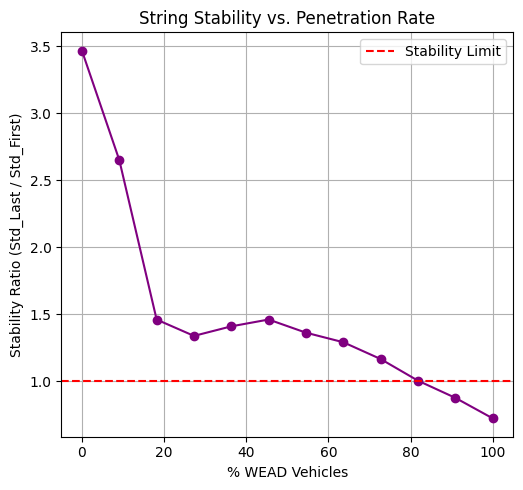

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
#  1. CONTROLLERS
# ============================================================

def wead_controller(sn, vn):
    # Parameters
    STOPPED_SPEED_TH = 1.0
    STOPPED_MIN_GAP = 5.0
    STOPPED_ACCEL = 1.0
    MAX_ACCEL = 2.5
    MAX_BRAKE = -2.5
    CRUISE_SPEED_LIMIT = 36.0

    # State 1: Stopped logic
    if vn <= STOPPED_SPEED_TH:
        if sn > STOPPED_MIN_GAP:
            return STOPPED_ACCEL
        else:
            return 0.0

    # State 2: Moving logic
    time_gap = sn / vn if vn > 0 else float('inf')

    if time_gap <= 3:
        return MAX_BRAKE
    elif time_gap < 4:
        return (2.5 * time_gap) - 10
    elif time_gap <= 5:
        return 0.0
    elif time_gap < 6:
        return (2.5 * time_gap) - 12.5
    elif time_gap >= 6:
        return MAX_ACCEL if vn <= CRUISE_SPEED_LIMIT else 0.0

    return 0.0

def profacc_controller(sn, vn, alpha=0.5, tau=1.2):
    return alpha * (sn - tau * vn)


# ============================================================
#  2. SIMULATION CORE
# ============================================================

def get_leader_velocity(t, profile_type, target_speed=20.0):
    """
    Generates different leader profiles for different tests.
    """
    if profile_type == "constant":
        # Ramps up to target_speed and holds it. Used for Fundamental Diagram.
        if t < 10:
            return (target_speed / 10.0) * t
        else:
            return target_speed
            
    elif profile_type == "sine_wave":
        # Oscillates around 20 m/s. Used for Stability/Energy analysis.
        base_speed = 20.0
        return base_speed + 3.0 * np.sin(0.3 * t)
    
    elif profile_type == "stop_and_go":
        # Brakes to a stop then recovers.
        if t < 10: return 20.0
        elif t < 15: return max(0, 20.0 - 4.0 * (t-10))
        elif t < 25: return 0.0
        else: return min(20.0, (t-25) * 2.0)
        
    return 20.0

def simulate_platoon(num_wead_cars, profile_type="constant", target_speed=20.0):
    """
    Simulates a 12-car platoon (1 Leader + 11 Followers).
    Returns time, positions, velocities, and accelerations.
    """
    dt = 0.05
    T = 60 # Duration
    N = int(T/dt)
    t = np.linspace(0, T, N)
    
    # 12 Cars: Index 0 is Leader, 1-11 are Followers
    total_cars = 12
    
    # Assign controllers (Interspersed logic)
    # Default everyone to PROFACC
    controllers = ["LEADER"] + ["PROFACC"] * (total_cars - 1)
    
    # Intersparse WEAD cars
    # We map 'num_wead_cars' across the 11 followers
    followers_indices = list(range(1, total_cars))
    if num_wead_cars > 0:
        spacing = len(followers_indices) / num_wead_cars
        for i in range(num_wead_cars):
            idx = int(i * spacing)
            if idx < len(followers_indices):
                real_idx = followers_indices[idx]
                controllers[real_idx] = "WEAD"

    # State arrays
    x = np.zeros((total_cars, N))
    v = np.zeros((total_cars, N))
    a = np.zeros((total_cars, N))
    
    # Initial spacing
    init_spacing = 20.0
    for i in range(total_cars):
        x[i, 0] = -init_spacing * i
        v[i, 0] = 0 # Start from stop to let them stabilize

    # Main Loop
    for k in range(1, N):
        # 1. Update Leader
        v[0, k] = get_leader_velocity(t[k], profile_type, target_speed)
        x[0, k] = x[0, k-1] + v[0, k] * dt
        
        # 2. Update Followers
        for i in range(1, total_cars):
            sn = x[i-1, k-1] - x[i, k-1] # Gap to car in front
            vn = v[i, k-1]               # Own velocity
            
            if controllers[i] == "WEAD":
                acc = wead_controller(sn, vn)
            else:
                acc = profacc_controller(sn, vn)
            
            a[i, k] = acc
            v[i, k] = max(0, v[i, k-1] + acc * dt) # No reversing
            x[i, k] = x[i, k-1] + v[i, k] * dt
            
    return t, x, v, a


# ============================================================
#  3. ANALYSIS FUNCTIONS
# ============================================================

def run_fundamental_diagram_analysis():
    """
    Generates the Flow (q) vs Density (k) curve.
    Varies the leader speed to find equilibrium gaps.
    """
    print("Running Fundamental Diagram Analysis...")
    
    # Test speeds (m/s) - we use this to sweep through densities
    target_speeds = np.arange(2, 38, 2) 
    
    penetration_scenarios = {
        "0% WEAD": 0,
        "25% WEAD": 3,
        "50% WEAD": 6,
        "75% WEAD": 9, 
        "100% WEAD": 12
    }
    
    plt.figure(figsize=(10, 6))
    
    for label, num_wead in penetration_scenarios.items():
        densities = [] # k (veh/km)
        flows = []     # q (veh/hr)
        
        for v_target in target_speeds:
            # Run simulation with constant speed
            _, x, v, _ = simulate_platoon(num_wead, profile_type="constant", target_speed=v_target)
            
            # Take the average of the last 10 seconds (steady state)
            # Exclude leader from average
            last_steps = int(10 / 0.05) # Last 10 seconds
            
            # Calculate average gap in the platoon
            # Gap = (Position of Car 1 - Position of Car 11) / 10 gaps
            platoon_length = np.mean(x[1, -last_steps:] - x[11, -last_steps:])
            avg_gap = platoon_length / 10.0
            
            # Calculate Density k (veh/km)
            # k = 1000 / (avg_gap + car_length)
            car_length = 5.0
            k = 1000.0 / (avg_gap + car_length)
            
            # Calculate Flow q (veh/hr)
            # q = k * v * 3.6
            # Use actual average velocity of followers, not target speed
            avg_v_platoon = np.mean(v[1:, -last_steps:])
            q = k * avg_v_platoon * 3.6
            
            densities.append(k)
            flows.append(q)
            
        plt.plot(densities, flows, '-o', linewidth=2, label=label)
        
    plt.title("Fundamental Diagram: Flow vs. Density")
    plt.xlabel("Density (veh/km)")
    plt.ylabel("Flow (veh/hr)")
    plt.legend()
    plt.grid(True)
    plt.show()

def run_stability_and_energy_analysis():
    """
    Analyzes String Stability and Energy Consumption varying penetration rate.
    Uses a Sine Wave disturbance.
    """
    print("Running Stability & Energy Analysis...")
    
    # We test every possible number of WEAD cars (0 to 11)
    wead_counts = range(0, 12)
    penetration_rates = [ (n / 11.0) * 100 for n in wead_counts ]
    
    stability_ratios = []
    energies = []
    
    for n in wead_counts:
        # Run with Sine Wave disturbance
        _, _, v, a = simulate_platoon(n, profile_type="sine_wave")
        
        # --- Metric 1: String Stability ---
        # Ratio of StdDev(Velocity) of Last Car / First Follower
        # > 1 means unstable (amplified), < 1 means stable (dampened)
        std_first = np.std(v[1, :]) # Car 1
        std_last = np.std(v[11, :]) # Car 11
        
        ratio = std_last / std_first if std_first != 0 else 0
        stability_ratios.append(ratio)

        
    # Plot Stability
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(penetration_rates, stability_ratios, '-o', color='purple')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Stability Limit')
    plt.title("String Stability vs. Penetration Rate")
    plt.xlabel("% WEAD Vehicles")
    plt.ylabel("Stability Ratio (Std_Last / Std_First)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run the full analysis suite
    run_fundamental_diagram_analysis()
    run_stability_and_energy_analysis()